Intro for all models; this'll be the same for everyone; post any changes so that everyone can do it

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report,f1_score,roc_auc_score
from sklearn import preprocessing

In [32]:
#df=pd.read_excel('CleanData_ForModeling.xlsx')
df=pd.read_excel('CleanData_ForPresentation_No_Normalization.xlsx')

print(df.shape)
df = df[(df['termination_date'] > '2022-1-1') | df['termination_date'].isna()]
print(df.shape)

In [34]:
#this should've been done in the data cleaning step, Nehal can you add this to our later reports/ppt as part of data cleaning?
df=df[((df['term_category'].isna())&(df['employee_status']=='Active'))|((df['term_category']=='Voluntary Termination')&(df['employee_status']=='Terminated'))]
#output var creation
df['employee_status']=df['employee_status'].apply(lambda x: 1 if x=='Terminated' else 0)

In [35]:
#these vars can directly predict output variable; need to drop them for sure
#work structure has a very high correlation with the output, hence dropped. base_pay_mid_point has high correlation with Salary, hence dropped
df.drop(['term_category','termination_reason','termination_date','last_promotion_date','work_structure','base_pay_mid_point'],axis=1,inplace=True)

In [37]:
#Changing date columns to years
#Should've been in data cleaning too 

for d in [col for col in df.columns if 'date' in col]:
    df[d]=df[d].apply(lambda x: str(x.year))

#Binning data based on quartiles
#dropping old columns here
for col in [col for col in df.columns if 'date' in col]:
    print(col)
    # Fill null values
    df[col].fillna('NA', inplace=True)

    # Get value counts of each category
    value_counts = df[col].value_counts()

    # Define bins based on quartiles
    bins = [0, value_counts.quantile(0.25), value_counts.quantile(0.5), value_counts.quantile(0.75), np.inf]
    labels = ['Q1', 'Q2', 'Q3', 'Q4']

    # Creating new variable name for the binned data
    new_var = col + '_q_binned'

    # Bin categories based on quartiles
    df[new_var] = pd.cut(df[col].map(value_counts), bins=bins, labels=labels, include_lowest=True)
    
    #dropping old date columns
    #TODO - need to map quartiles to old years to understand 
    df.drop(col,axis=1,inplace=True)
    print(new_var)

current_hire_date
current_hire_date_q_binned
continuous_service_date
continuous_service_date_q_binned


In [26]:
# More data cleaning steps; need to add as having been done before in data cleaning report
df['days_since_promotion'][df['days_since_promotion'].isna()]=-1
df['marital_status'][df['marital_status'].isna()]='NA'

C:\Users\Tweek\AppData\Local\Temp\ipykernel_13332\1628455201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_promotion'][df['days_since_promotion'].isna()]=-1
C:\Users\Tweek\AppData\Local\Temp\ipykernel_13332\1628455201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital_status'][df['marital_status'].isna()]='NA'


In [27]:
#Creating dummies and replacing them in the original data


num_cols=[]
cat_cols=[]
for x in df.columns:  
    if df[x].dtype=='object':
        cat_cols.append(x)
    elif len(set(df[x]))<10:
        cat_cols.append(x)
    else:
        num_cols.append(x)
        
print(num_cols)
print(cat_cols)


#Getting dummies for variables, drop old ones
for var in cat_cols:
    if var not in ['employee_status','cost_to_replace_factor']:
        dummies = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(var,axis=1,inplace=True)

['Unnamed: 0', 'years_of_service', 'compa_ratio', 'age', 'lat', 'longi', 'salary', 'replacement_cost', 'days_since_promotion']
['employee_status', 'employee_type', 'location', 'country', 'region', 'job_title', 'job_category', 'job_function', 'job_family', 'management_level', 'pay_level', 'organization', 'marital_status', 'generation', 'race/ethnicity', 'gender', 'cost_to_replace_factor', 'location_q_binned', 'country_q_binned', 'job_title_q_binned', 'job_function_q_binned', 'job_family_q_binned', 'pay_level_q_binned', 'organization_q_binned', 'race/ethnicity_q_binned', 'current_hire_date_q_binned', 'continuous_service_date_q_binned']


In [38]:
df.columns

Index(['Unnamed: 0', 'employee_status', 'employee_type', 'years_of_service',
       'location', 'country', 'region', 'job_title', 'job_category',
       'job_function', 'job_family', 'management_level', 'pay_level',
       'organization', 'compa_ratio', 'marital_status', 'age', 'generation',
       'race/ethnicity', 'gender', 'cost_to_replace_factor',
       'location_q_binned', 'country_q_binned', 'job_title_q_binned',
       'job_function_q_binned', 'job_family_q_binned', 'pay_level_q_binned',
       'organization_q_binned', 'race/ethnicity_q_binned', 'lat', 'longi',
       'salary', 'replacement_cost', 'days_since_promotion',
       'current_hire_date_q_binned', 'continuous_service_date_q_binned'],
      dtype='object')

In [29]:
# calculate correlation matrix
corr_matrix = df.corr()

# display correlation matrix with just the correlations for the target variable
# sort correlation matrix by correlations with the target variable, in descending order
corr_matrix_sorted = corr_matrix['employee_status'].sort_values(ascending=False)

# display sorted correlation matrix
print(corr_matrix_sorted)

employee_status                                 1.000000
organization_Emerging Products and Solutions    0.136305
generation_Millennial                           0.096076
location_Pune India                             0.083246
organization_Enterprise Software Development    0.081390
                                                  ...   
continuous_service_date_q_binned_Q2            -0.069631
generation_Gen X                               -0.095478
days_since_promotion                           -0.104218
age                                            -0.113645
years_of_service                               -0.156316
Name: employee_status, Length: 1105, dtype: float64


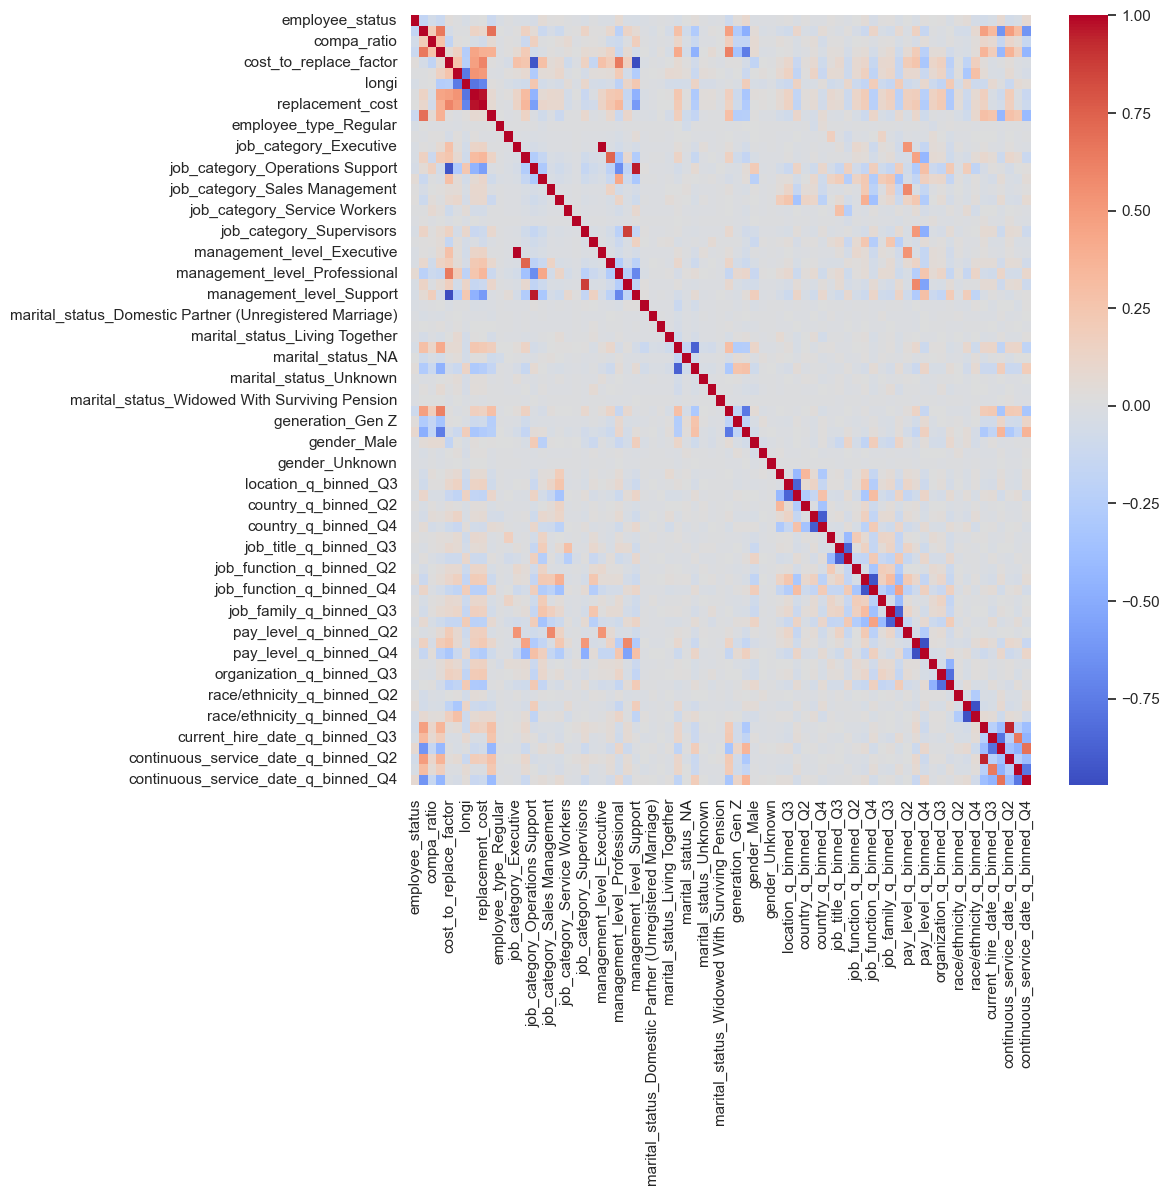

In [18]:
# Set style and color palette
sns.set(style="white")
sns.set_palette("coolwarm")

# Create heatmap with correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
# plot correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap="coolwarm")
# show the plot
plt.show()

In [39]:
df.to_excel('ModelingDataset-LastYear-NoNormalization.xlsx')

Modelling (use your code here)

In [4]:
df=pd.read_excel('ModelingDataset.xlsx')

In [5]:
# set random seed
random_seed = 42

In [6]:
# separate features and target variable
X = df.drop('employee_status', axis=1)
y = df['employee_status']

# split data into train and test sets, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)

# check the ratio of binary variable in train and test set
print("Ratio of binary variable in train set: ", y_train.sum() / len(y_train))
print("Ratio of binary variable in test set: ", y_test.sum() / len(y_test))


Ratio of binary variable in train set:  0.27165354330708663
Ratio of binary variable in test set:  0.2716089880268985


In [7]:
le = preprocessing.LabelEncoder()


In [8]:
from sklearn.naive_bayes import GaussianNB

In [9]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [10]:
# train logistic regression model
clf = LogisticRegression(random_state=random_seed)
clf.fit(X_train, y_train)

# make predictions on test set
y_pred = clf.predict(X_test)

c:\users\tweek\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics

In [12]:
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# display evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

Accuracy: 0.793997047728391
Precision: 0.676678445229682
Recall: 0.46256038647342995
Confusion matrix:
[[4075  366]
 [ 890  766]]


In [15]:
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("F1 score:", f1)
print("AUC score:", auc_score)

F1 score: 0.5494978479196557
AUC score: 0.6900732578617994
